# Nickolas4 - Cross Asset Monitor

In [1]:
import numpy as np
import pandas as pd
import quandl
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_datareader import DataReader as dr
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [2]:
quandl.ApiConfig.api_key = "8u9meDr5sQxGim8ATVt6"

In [3]:
indices = {'S&P 500':'CHRIS/CME_ES1.6',
     'IBOV':'CHRIS/CME_IBV1.6',
     'Nikkei':'NIKKEI/INDEX.4',
    'FTSE 100':'LSE/S100.4',
    'TSX':'FRED/DEXCAUS'}

rates = {'US 10Y':'FRED/DGS10',
         'CDI':'BCB/4389',
         'Japan 10Y':'MOFJ/INTEREST_RATE_JAPAN_10Y',
         'UK 10Y':'BOE/IUDMNPY',
         'Canada 10Y': 'BOC/V39055',
         'Germany 10Y':'BUNDESBANK/BBK01_WT1010',
         'Aussie 10Y':'RBA/F02.3'}

currencies = {'Dollar TWI':'FRED/DTWEXM',
             'EURUSD':'FRED/DEXUSEU',
             'USDJPY':'FRED/DEXJPUS',
             'USDBRL':'FRED/DEXBZUS',
             'AUDUSD':'FRED/DEXUSAL',
             'USDCAD':'FRED/DEXCAUS'}

credit = {'US A-rated':'ML/ATRI',
          'US BB-rated':'ML/BBTRI',
          'US BBB-rated':'ML/BBTRI',
         'EM Corps':'ML/EMCTRI',
         'EM IG':'ML/IGEM'}


commodities = {'WTI':'CHRIS/CME_CL1.4',
               'Gold':'CHRIS/CME_GC1.4',
               'Natural Gas':'CHRIS/CME_NG1.4',
               'Silver':'CHRIS/CME_SI1.4',
               'Corn':'CHRIS/CME_C1.4',
               'Wheat':'CHRIS/CME_W1.4'}

div_yield = {'S&P 500':'MULTPL/SP500_DIV_YIELD_MONTH'}

valuation = {'S&P 500': 'MULTPL/SP500_PE_RATIO_MONTH',
            'S&P 500 Schiller':'MULTPL/SHILLER_PE_RATIO_MONTH',
            'EURUSD':'FRED/DEXUSEU',
            'USDBRL':'FRED/DEXBZUS',
            'AUDUSD':'FRED/DEXUSAL', 
            'US 10Y':'FRED/DGS10',
            'Germany 10Y':'BUNDESBANK/BBK01_WT1010',
            'UK 10Y':'BOE/IUDMNPY'}

yields = {'S&P 500':'MULTPL/SP500_DIV_YIELD_MONTH',
         'US 10Y':'FRED/DGS10',
         'CDI':'BCB/4389',
         'Japan 10Y':'MOFJ/INTEREST_RATE_JAPAN_10Y',
         'UK 10Y':'BOE/IUDMNPY',
         'Canada 10Y': 'BOC/V39055',
         'Germany 10Y':'BUNDESBANK/BBK01_WT1010',
         'Aussie 10Y':'RBA/F02.3',
         'Swiss 10Y':'SNB/RENDOBLID.9',
         'US AAA rated':'ML/AAAEY',
         'US AA rated':'ML/AAY',
         'US A rated':'ML/AEY',
         'US BBB rated':'ML/BBBEY',
         'US BB rated':'ML/BBY',
         'US B rated':'ML/BEY',
         'US CCC rated':'ML/CCCY',
         'US Corporates':'ML/USEY',
         'US High Yield':'ML/USTRI',
         'EM High Grade':'ML/EMHGY',
         'Euro EM':'ML/EEMCBI'}

#### Create Dictionary w/ Market Prices of Asset Classes

In [4]:
#Iterate over Asset Class dictionaries
product = [indices, rates, currencies, credit, commodities]
df_names = ['acoes', 'juros','fx','credito','cmds']
asset_classes = {}

#Function to generate Dataframes within an empty dictionary
def get_data(start, end, collapse, transform):
    count = 0
    for i in df_names:
        asset_classes[i] = quandl.get(list(product[count].values()), start_date=start, end_date=end, collapse=collapse, transform=transform)
        asset_classes[i].columns = product[count].keys()
        count+=1
        print count

#### Data Criteria 

In [5]:
start = '01-01-2000'
end = '31-12-2017'
collapse='daily'
transform = 'none'

#### Generate Data

In [6]:
#Generate Data 
get_data(start=start, end=end, collapse=collapse,transform=transform)

1
2
3
4
5


#### Pull data separately from Google & Merge w/Data

In [7]:
# DF of Asset Class Nominal Prices (DAILY)
all_assets = pd.concat([asset_classes['fx'], asset_classes['cmds'], asset_classes['credito'], asset_classes['acoes'], asset_classes['juros']], axis=1, join='inner')

#Alter IBOV & TSX columns (pulling data from google)
IBOV = dr('INDEXBVMF:IBOV',data_source='google',start=start,end=end)['Close']
TSX = dr('INDEXTSI:OSPTX',data_source='google', start=start, end=end)['Close']
both = pd.concat([IBOV, TSX], axis=1)
both.columns=['X','Y']

#Join Dataframes & drop extra column values
all_assets = all_assets.join(both, how='outer')
all_assets.IBOV = all_assets.X.values
all_assets.TSX = all_assets.Y.values
del all_assets['X']
del all_assets['Y']

#Drop NANs
all_assets.fillna(method='ffill', inplace=True)
all_assets.fillna(method='bfill', inplace=True)
all_assets.head()

,AUDUSD,EURUSD,Dollar TWI,USDJPY,USDBRL,USDCAD,Wheat,Gold,Natural Gas,Corn,...,TSX,IBOV,S&P 500,UK 10Y,Germany 10Y,US 10Y,CDI,Aussie 10Y,Japan 10Y,Canada 10Y
2000-01-03,0.6591,1.0155,95.4007,101.70,1.8050,1.4465,247.50,283.7,2.176,200.75,...,7530.56,13228.78,1466.75,5.7230,4.78,6.58,18.78,2.76,1.743,5.53
2000-01-04,0.6562,1.0309,95.2537,103.09,1.8405,1.4518,247.25,283.7,2.176,203.00,...,7530.56,13228.78,1411.50,5.7230,4.78,6.49,18.75,2.76,1.743,5.53
2000-01-05,0.6550,1.0335,95.2929,103.77,1.8560,1.4518,249.75,282.1,2.168,203.00,...,7530.56,13228.78,1413.00,5.8037,4.78,6.62,18.74,2.76,1.718,5.53
2000-01-06,0.6540,1.0324,95.6984,105.19,1.8400,1.4571,248.50,282.4,2.196,203.75,...,7530.56,13228.78,1404.75,5.8087,4.78,6.57,18.75,2.76,1.710,5.53
2000-01-07,0.6548,1.0294,95.7234,105.17,1.8310,1.4505,251.75,282.9,2.173,207.00,...,7530.56,13228.78,1459.75,5.7565,4.78,6.52,18.75,2.76,1.738,5.53


#### Designated Objects

In [8]:
# DF of Asset Class Nominal Prices (Weekly).... Reindexed to weekly, Fridays
weekly_returns = all_assets.reindex(pd.date_range(start=all_assets.index.min(), 
                                                  end=all_assets.index.max(),freq='W-FRI')) 

# Daily Returns
returns_daily = np.log(all_assets/all_assets.shift(1).fillna(method='bfill')).fillna(method='bfill')

#Rolling Annualized Standard Deviation
rolling_stdev = pd.rolling_std(returns_daily, window=252).dropna() * np.sqrt(252)

#DataFrame of Valuations (Monthly)
valuations = quandl.get(valuation.values(), collapse='monthly')
valuations.columns = valuation.keys()

#DataFrame of Asset Yields (Monthly)
asset_yields = quandl.get(yields.values(), start_date='01-01-1995', end_date='01-01-2017',collapse='monthly')
asset_yields.columns = yields.keys()

# DF of Asset Class Nominal Prices (DAILY)
all_assets = pd.concat([asset_classes['fx'], asset_classes['cmds'], asset_classes['credito'], asset_classes['acoes'], asset_classes['juros']], axis=1, join='inner')

# 1.) Cross-Asset Performance

### I.) 1-Week Returns

In [9]:
def performance(data,rates,weeks):
    x = np.log(data/data.shift(1))
    x = x.iloc[:,:-7]
    x.fillna(method='bfill',inplace=True)
    rets = x.iloc[-weeks,:]    
    
    y = data.iloc[:,-7:]
    yld_delta = np.subtract(y.iloc[-1,:],y.iloc[-1-weeks,:])
    
    # 2 Different SubPlot Types to Visualize Data
    y_pos = np.arange(len(rets))
    plt.figure(figsize=(20,10))
    plt.subplot(121)   #first subplot
    plt.bar(y_pos, np.array(rets))
    plt.grid(True)
    plt.legend(loc=0)
    plt.ylabel('Returns (%)', fontsize=18)
    plt.title('Weekly Returns', fontsize=20)
    plt.xticks(y_pos, rets.index, rotation=90)
    
    #second subplot
    y_pos2 = np.arange(len(yld_delta))
    plt.subplot(122)    
    plt.bar(y_pos2, np.array(yld_delta), width=0.5)
    plt.legend(loc=0)
    plt.ylabel('Delta in Basis Points', fontsize=18)
    plt.title('Weekly Yield Change (Basis Points)', fontsize=20)
    plt.xticks(y_pos2, yld_delta.index, rotation=90)
    plt.ylim(-0.12,0.12)

    #Increasing the X and Y axes text sizes
    label_size = 18
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    plt.tight_layout()
    plt.show()

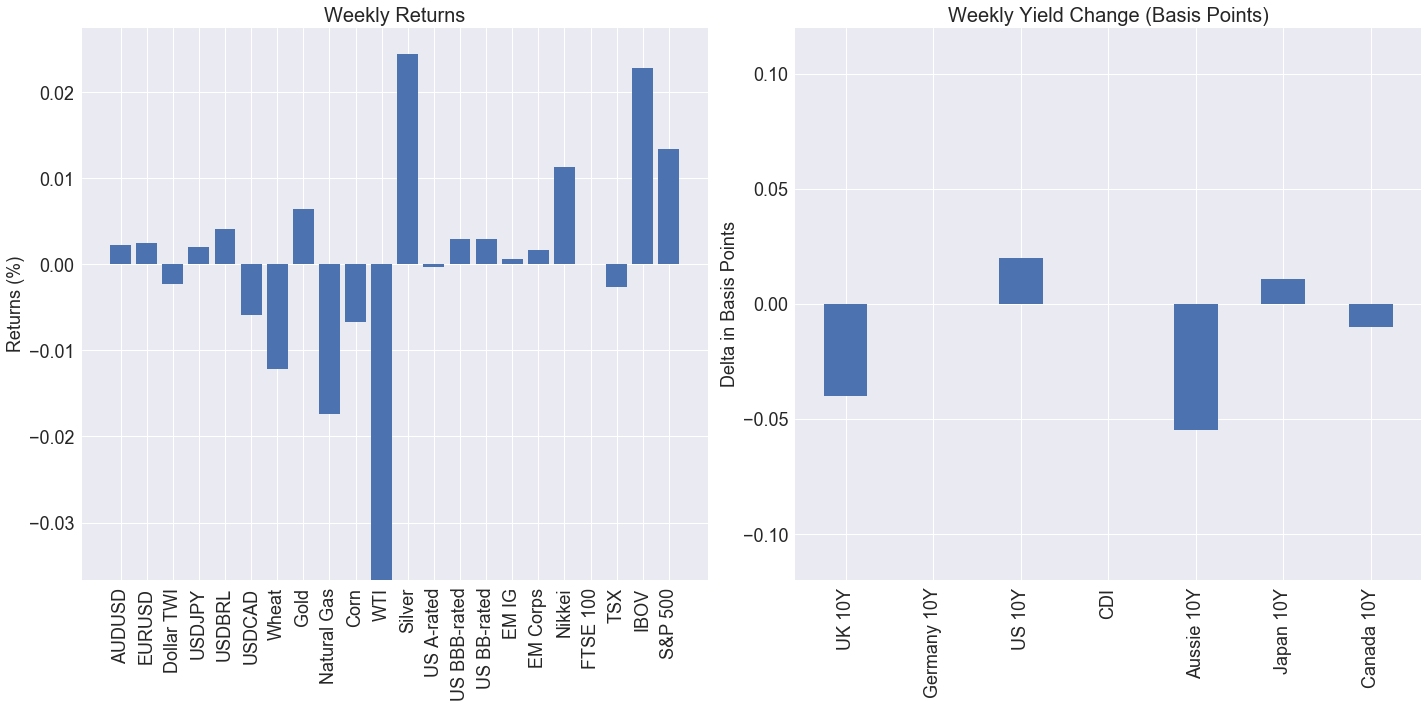

In [12]:
performance(weekly_returns, rates=asset_classes['juros'], weeks=1)

### II.) 1-Year Returns

In [13]:
#Function to generate Annual Performance series
def annual_performance(data, years=1):
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    df = (data.iloc[-1,:]/data.iloc[-252*years,:])-1
    df['Germany 10Y'] = data['Germany 10Y'].iloc[-1] - data['Germany 10Y'].iloc[-252*years]
    df['US 10Y'] = data['US 10Y'].iloc[-1] - data['US 10Y'].iloc[-252*years]
    df['CDI'] = data['CDI'].iloc[-1] - data['CDI'].iloc[-252*years]
    df['Japan 10Y'] = data['Japan 10Y'].iloc[-1] - data['Japan 10Y'].iloc[-252*years]
    df['UK 10Y'] = data['UK 10Y'].iloc[-1] - data['UK 10Y'].iloc[-252*years]
    df['Canada 10Y'] = data['Canada 10Y'].iloc[-1] - data['Canada 10Y'].iloc[-252*years]
    return df

#Save the Pandas Series under object name
annual_returns = annual_performance(all_assets)

#Separate rates from other assets
rates = annual_returns.iloc[-7:]
assets = annual_returns.iloc[:-7]

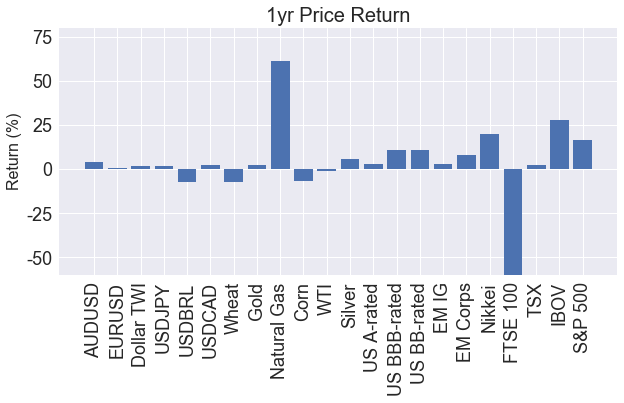

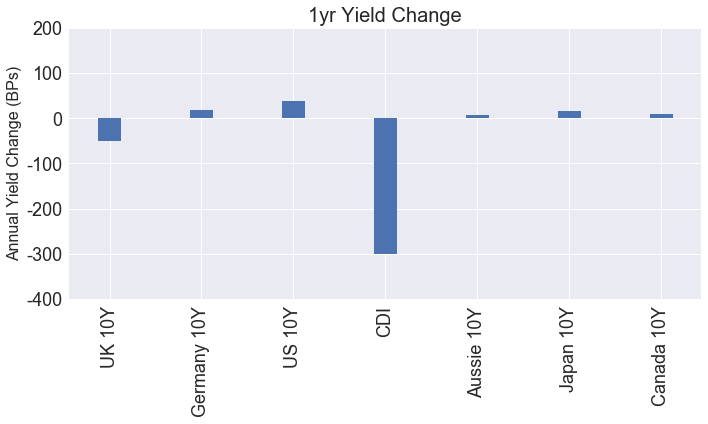

In [15]:
from matplotlib.ticker import FuncFormatter 

#Function to generate format
def myfunc(x, pos=0): 
    return '%1.0f'%(100*x) 

#Plot 1
ax = plt.subplot(212) 
ax.bar(np.arange(len(assets)), assets)
ax.yaxis.set_major_formatter(FuncFormatter(myfunc))
ax.set_ylabel('Return (%)', fontsize=16)
ax.set_ylim(bottom = -0.6, top = 0.8)
mpl.rcParams['figure.figsize'] = [10, 10] #Figure Size
plt.xticks(np.arange(len(assets)), assets.index, rotation=90) #X-labels
plt.title('1yr Price Return', fontsize=20)
plt.show()


#Plot 2
ax = plt.subplot(212) 
ax.bar(np.arange(len(rates)), rates, width=0.25)
ax.yaxis.set_major_formatter(FuncFormatter(myfunc))
ax.set_ylabel('Annual Yield Change (BPs)', fontsize=16)
ax.set_ylim(bottom=-4, top=2)
mpl.rcParams['figure.figsize'] = [10, 10] #Figure Size
plt.xticks(np.arange(len(rates)), rates.index, rotation=90) #X-labels
plt.title('1yr Yield Change', fontsize=20)
plt.tight_layout()
plt.show()

# 2.) Cross-Asset: Volatility

### I.) Annualized Standard Deviation

In [21]:
def annual_volatility(data, years=1):
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    log_rets = np.log(data/data.shift(1))
    rets = (data.iloc[-1,:]/data.iloc[-252*years,:])-1
    stdev = np.std(log_rets)*np.sqrt(252)
    del stdev['Germany 10Y']
    del stdev['Japan 10Y']
    del stdev['Canada 10Y']    
    del stdev['UK 10Y']
    return stdev

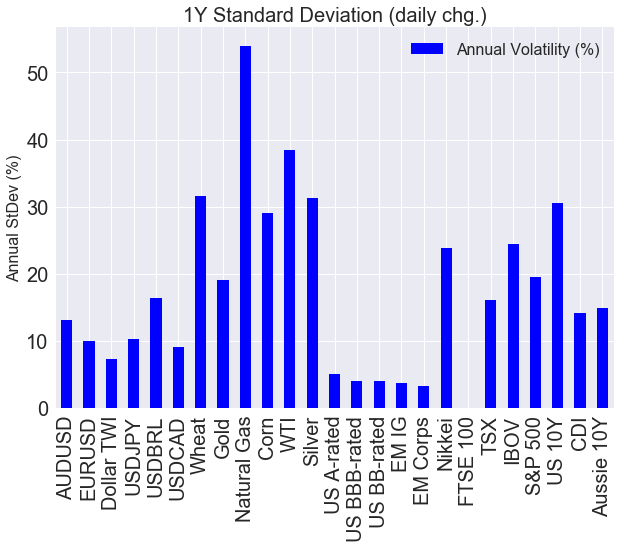

In [22]:
annual_stdev = annual_volatility(all_assets,years=1)*100
ax = annual_stdev.plot.bar(figsize=(10,7), label='Annual Volatility (%)',
                      legend=True,grid=True, color='b', fontsize=20)
ax.set_ylabel('Annual StDev (%)', fontsize=16)
ax.legend(loc=0, fontsize=16)
plt.title('1Y Standard Deviation (daily chg.)',fontsize=20)

### II.) Rolling Annual Standard Deviation

In [23]:
def rolling_stdev(data, assets):
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    log_rets = np.log(data/data.shift(1))
    stdev = pd.rolling_std(log_rets, window=252)*np.sqrt(252)
    stdev.fillna(value=0, inplace=True)
    return stdev[assets]

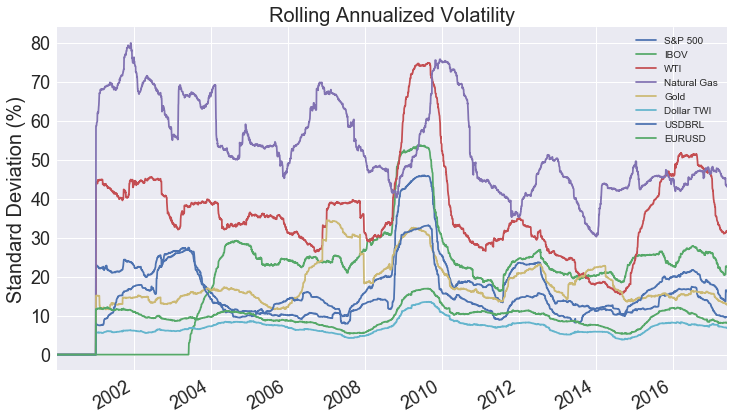

In [24]:
#Select Assets to plot
rolling_vol = rolling_stdev(data = all_assets, 
                            assets=['S&P 500', 'IBOV', 'WTI','Natural Gas','Gold','Dollar TWI','USDBRL', 'EURUSD'])*100
#Plot Data
ax = rolling_vol.plot(figsize=(12,7))
ax.legend(loc=0)
ax.set_ylabel('Standard Deviation (%)', fontsize=20)
plt.title('Rolling Annualized Volatility', fontsize=20)

### III.) Realised Volatility

In [9]:
def cross_vol(data):
    
    #Create empty DataFrame to store Stats
    df = pd.DataFrame(index=['Monthly Realised Volatility','Current (M)', 'Average (M)', 'Percentile (M)','5th','95th', 
                             'Annual Realised Volatility','Current (Y)', 'Average (Y)', 'Percentile (Y)', '5th %ile','95th %ile'], 
                      columns=data.columns)
    df.fillna(value='', inplace=True)
    
    #Log Returns
    logrets_annual = np.log(data/data.shift(1)).dropna()
        
    #Reiterate over each row/column
    for i in df.columns:
        
        df[i]['Current (M)'] = (np.std(logrets_annual[i].iloc[-30:])*np.sqrt(30)*100).round(1)
        df[i]['Average (M)'] = (np.average((pd.rolling_std(logrets_annual[i], window=30)*np.sqrt(30)).dropna())*100).round(1)
        df[i]['Percentile (M)'] = (stats.percentileofscore((pd.rolling_std(logrets_annual[i], window=30)*np.sqrt(30)*100).dropna(),score=df[i]['Current (M)']).round(1))
        df[i]['5th'] = (np.percentile((pd.rolling_std(logrets_annual[i], window=30)*np.sqrt(30)*100).dropna(), q=5).round(1))
        df[i]['95th'] = (np.percentile((pd.rolling_std(logrets_annual[i], window=30)*np.sqrt(30)*100).dropna(), q=95).round(1))
        
        #Annual Data
        df[i]['Current (Y)'] = (np.std(logrets_annual[i].iloc[-252:])*np.sqrt(252)*100).round(1)
        df[i]['Average (Y)'] = (np.average((pd.rolling_std(logrets_annual[i], window=252)*np.sqrt(252)).dropna())*100).round(1)
        df[i]['Percentile (Y)'] = (stats.percentileofscore((pd.rolling_std(logrets_annual[i], window=252)*np.sqrt(252)*100).dropna(),score=df[i]['Current (Y)']).round(1))
        df[i]['5th %ile'] = (np.percentile((pd.rolling_std(logrets_annual[i], window=252)*np.sqrt(252)*100).dropna(), q=5).round(1))
        df[i]['95th %ile'] = (np.percentile((pd.rolling_std(logrets_annual[i], window=252)*np.sqrt(252)*100).dropna(), q=95).round(1))
    return df

#Exclude 10Y Rates Volatility
cross_vols = cross_vol(all_assets)
cross_vols

/Users/NABRARPOUR4/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,AUDUSD,EURUSD,Dollar TWI,USDJPY,USDBRL,USDCAD,Wheat,Gold,Natural Gas,Corn,...,TSX,IBOV,S&P 500,UK 10Y,Germany 10Y,US 10Y,CDI,Aussie 10Y,Japan 10Y,Canada 10Y
Monthly Realised Volatility,,,,,,,,,,,...,,,,,,,,,,
Current (M),2.4,2,1.7,2.8,3.8,1.8,8.3,3.7,13.8,4.9,...,1.8,6.9,1.6,15.9,51.5,7.7,10.1,6.9,101.6,11.1
Average (M),4,3.4,2.5,3.5,6.1,3,9.1,5.3,14.9,7.7,...,3,8.9,4.6,16.6,50.4,12.5,2.4,11.6,72.1,15.8
Percentile (M),0.8,9.3,10.1,31.3,11.7,5.8,29.4,3.5,37.2,6.8,...,5.8,12.8,0.4,48.1,63.4,8.6,98.4,3.3,72,22.4
5th,2.8,1.9,1.5,1.9,3.5,1.8,5.3,3.8,9.4,4.8,...,1.8,6.2,2.2,6.9,10.2,7.4,0,7.1,10.9,6.9
95th,5.3,4.6,3.6,5.1,8.9,4.9,13.3,8.2,21.7,11.9,...,4.9,12.5,8.5,37,105.2,16.7,8.2,16.9,250.4,21.8
Annual Realised Volatility,,,,,,,,,,,...,,,,,,,,,,
Current (Y),12,9.9,7.8,11.5,19.7,9.7,25.5,14.4,46.5,21.5,...,9.7,28.6,14.3,63.7,NaN,37.2,12.1,33.4,424.4,52.5
Average (Y),12.5,10.9,7.8,10.1,19.7,9.4,28.9,14.9,44.7,24.2,...,9.4,26.3,16,50,155.1,38.1,7.4,36.1,249,49.7
Percentile (Y),28.4,4.2,40.2,83.3,39,43.2,2.3,15.9,79.9,0,...,43.2,86.7,6.4,83.3,NaN,26.9,94.7,0,97.7,55.7


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21]), <a list of 21 Text xticklabel objects>)

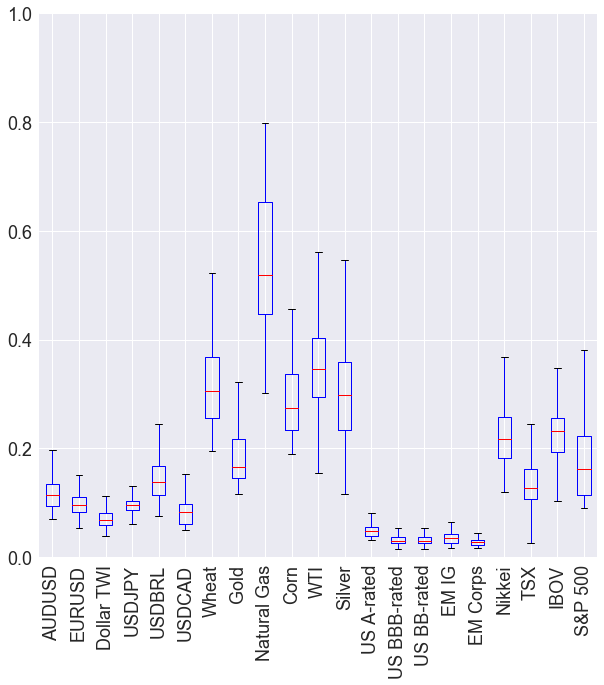

In [28]:
temp = rolling_stdev.iloc[:, :-7]
del temp['FTSE 100']
ax = temp.plot.box()
ax.set_ylim(bottom=0, top=1)
plt.xticks(rotation=90)

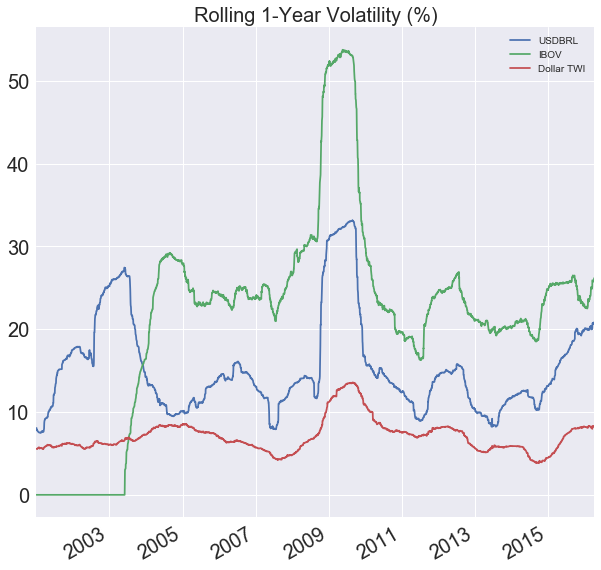

In [29]:
(rolling_stdev.USDBRL*100).plot(legend=True, fontsize=20)
(rolling_stdev.IBOV*100).plot(legend=True)
(rolling_stdev['Dollar TWI']*100).plot(legend=True)
plt.title('Rolling 1-Year Volatility (%)', fontsize=20)


# 3.) Cross-Asset: Correlation Matrix

#### I.) Correlation Matrices

#### Clean up the data

In [30]:
#Consolidate all DataFrames
df = pd.concat([asset_classes['fx'], asset_classes['juros'], asset_classes['credito'], asset_classes['acoes'], asset_classes['cmds']], axis=1, join='inner')

#Alter IBOV & TSX columns (pulling data from google)
IBOV = dr('INDEXBVMF:IBOV',data_source='google',start=start,end=end)['Close']
TSX = dr('INDEXTSI:OSPTX',data_source='google',start=start,end=end)['Close']
both = pd.concat([IBOV, TSX], axis=1, join='inner')
both.columns=['X','Y']

df = df.join(both,how='inner')
df.IBOV = df['X'].values
df.TSX = df['Y'].values
del df['X']
del df['Y']

#Drop NAN values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

### Correlation Matrix 1

In [31]:
def correlation(data):
    rets = np.log(df/df.shift(1))
    rets.fillna(value=0)
    corr = rets.iloc[-252:,:].corr()
    return corr

#Rename
corr = correlation(df)

#Create DF w/log returns of assets
rets = np.log(df/df.shift(1))
corr = rets.iloc[-252:,:].corr()
corr.round(2)

,AUDUSD,EURUSD,Dollar TWI,USDJPY,USDBRL,USDCAD,UK 10Y,Germany 10Y,US 10Y,CDI,...,FTSE 100,TSX,IBOV,S&P 500,Wheat,Gold,Natural Gas,Corn,WTI,Silver
AUDUSD,1.00,0.60,-0.70,-0.27,-0.43,-0.63,-0.07,0.07,-0.07,-0.18,...,-0.01,0.33,0.26,0.25,0.13,0.24,-0.06,0.12,0.21,0.40
EURUSD,0.60,1.00,-0.91,-0.41,-0.25,-0.49,-0.07,-0.02,-0.12,-0.13,...,-0.01,0.12,0.09,0.07,0.05,0.27,-0.01,0.04,0.04,0.39
Dollar TWI,-0.70,-0.91,1.00,0.55,0.28,0.75,0.11,0.03,0.19,0.15,...,0.05,-0.17,-0.13,-0.09,-0.11,-0.37,0.04,-0.07,-0.17,-0.47
USDJPY,-0.27,-0.41,0.55,1.00,0.06,0.22,0.40,0.06,0.54,0.12,...,0.09,0.16,0.08,0.32,-0.06,-0.64,0.05,-0.00,0.10,-0.41
USDBRL,-0.43,-0.25,0.28,0.06,1.00,0.31,0.10,-0.01,0.05,0.04,...,0.01,-0.31,-0.53,-0.25,-0.19,-0.14,-0.05,-0.20,-0.25,-0.22
USDCAD,-0.63,-0.49,0.75,0.22,0.31,1.00,0.02,0.02,0.07,0.10,...,0.06,-0.30,-0.22,-0.22,-0.14,-0.23,0.05,-0.15,-0.38,-0.39
UK 10Y,-0.07,-0.07,0.11,0.40,0.10,0.02,1.00,0.16,0.56,0.05,...,-0.01,0.03,-0.01,0.12,0.02,-0.38,-0.04,0.02,0.07,-0.28
Germany 10Y,0.07,-0.02,0.03,0.06,-0.01,0.02,0.16,1.00,0.05,0.04,...,0.03,0.09,0.05,0.10,-0.10,-0.05,-0.07,-0.14,0.00,0.00
US 10Y,-0.07,-0.12,0.19,0.54,0.05,0.07,0.56,0.05,1.00,0.06,...,0.09,0.13,0.01,0.35,-0.05,-0.61,0.01,-0.01,0.20,-0.39
CDI,-0.18,-0.13,0.15,0.12,0.04,0.10,0.05,0.04,0.06,1.00,...,0.01,0.11,0.07,0.07,0.02,-0.06,-0.07,0.02,-0.04,-0.05


### Correlation Matrix 2

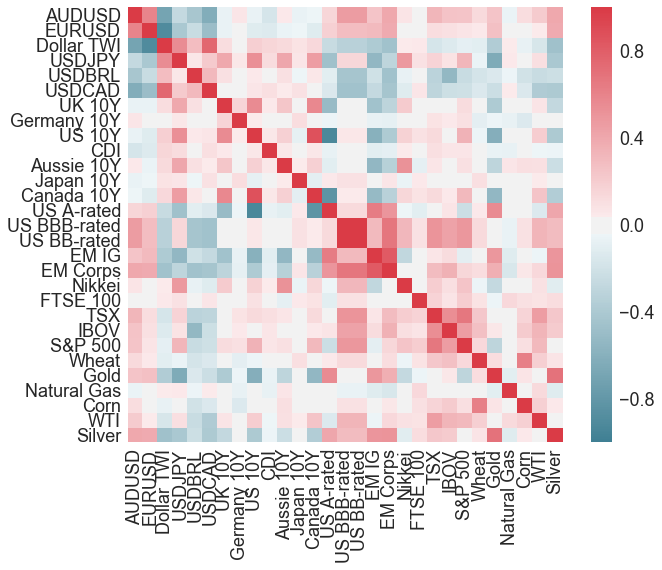

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### Correlation Matrix 3

In [33]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

### II.) Equity/Rates Correlations

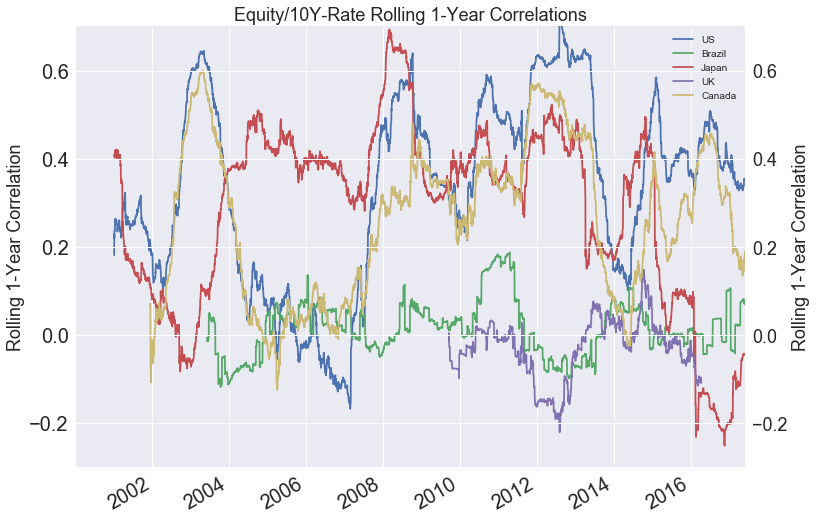

In [34]:
def rolling_corr(data):
    df = pd.DataFrame(columns=['US', 'Brazil', 'Japan', 'UK'])
    df['US'] = pd.rolling_corr(data['US 10Y'], data['S&P 500'], window=252)
    df['Brazil'] = pd.rolling_corr(data['CDI'], data['IBOV'], window=252)
    df['Japan'] = pd.rolling_corr(data['Japan 10Y'], data['Nikkei'], window=252)
    df['UK'] = pd.rolling_corr(data['UK 10Y'], data['FTSE 100'], window=252)
    df['Canada'] = pd.rolling_corr(data['Canada 10Y'], data['TSX'], window=252)
    return df

#Plot Equity/Rates Correlation
bond_stock_corr = rolling_corr(returns_daily)
ax = bond_stock_corr.plot(figsize=(12,9), fontsize=20, legend=True)
ax.set_ylim(bottom=-0.3, top=0.7)
ax.set_ylabel('Rolling 1-Year Correlation', fontsize=18)
ax.grid(True)
ax2 = ax.twinx()
ax2.set_ylim(bottom=-0.3, top=0.7)
ax2.set_ylabel('Rolling 1-Year Correlation', fontsize=18)
plt.title('Equity/10Y-Rate Rolling 1-Year Correlations', fontsize=18)

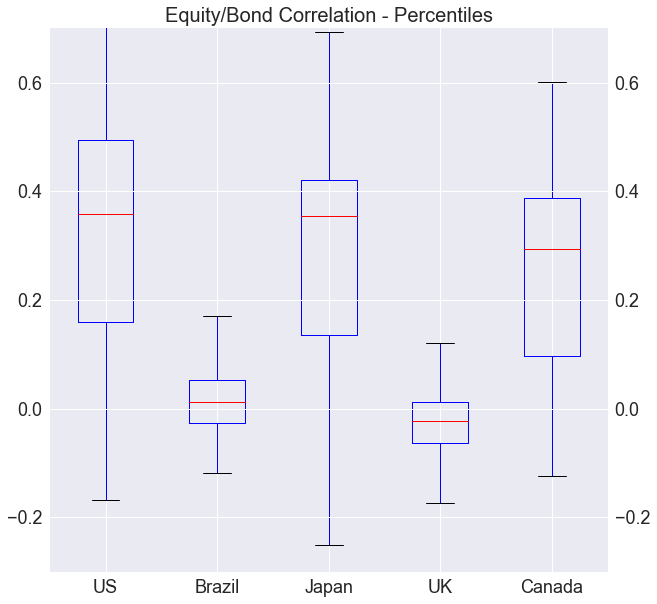

In [35]:
ax = bond_stock_corr.plot.box()
ax.set_ylim(bottom=-0.3, top=0.7)
ax.legend(loc=0)
ax2 = ax.twinx()
ax2.set_ylim(bottom=-0.3, top=0.7)
plt.title('Equity/Bond Correlation - Percentiles', fontsize=20)

In [36]:
#Equity/Rates Correlation - Percentiles
z = pd.DataFrame(columns=bond_stock_corr.columns,
    index=['Equity/Bonds','Correlation', 'Average','Percentiles', 'Current (%)', '95th %ile', '5th %ile'])

for i in z.columns:
    z[i]['Equity/Bonds'] = ''
    z[i]['Correlation'] = (bond_stock_corr[i].round(2).dropna().iloc[-1])
    z[i]['Average'] = np.average(bond_stock_corr[i].dropna()).round(2)
    z[i]['Percentiles'] = ''
    z[i]['Current (%)'] = stats.percentileofscore(a = bond_stock_corr[i].dropna(), score = z[i]['Correlation']).round(1)
    z[i]['95th %ile'] = np.percentile(a=bond_stock_corr[i].dropna(), q=95).round(2)
    z[i]['5th %ile'] = np.percentile(a=bond_stock_corr[i].dropna(), q=5).round(2)
z

,US,Brazil,Japan,UK,Canada
Equity/Bonds,,,,,
Correlation,0.35,0.07,-0.04,-0.11,0.19
Average,0.33,0.02,0.28,-0.03,0.26
Percentiles,,,,,
Current (%),48.4,84.3,10.1,13.8,35.6
95th %ile,0.63,0.15,0.54,0.07,0.55
5th %ile,-0.05,-0.08,-0.13,-0.16,-0


### III.) Bond Yield Correlations

#### Correlation Matrix 1

In [37]:
rates = asset_classes['juros']
rates = rates.drop('Aussie 10Y', axis=1)
rates.dropna(inplace=True)
log_rates = np.log(rates/rates.shift(1)).dropna()
log_rates.columns = ['UK', 'Germany','US', 'CDI', 'Japan', 'Canada']
log_rates.corr().round(2)

,UK,Germany,US,CDI,Japan,Canada
UK,1.00,0.21,0.56,0.02,0.03,0.59
Germany,0.21,1.00,0.10,0.03,0.11,0.09
US,0.56,0.10,1.00,0.01,0.03,0.81
CDI,0.02,0.03,0.01,1.00,-0.00,0.02
Japan,0.03,0.11,0.03,-0.00,1.00,0.03
Canada,0.59,0.09,0.81,0.02,0.03,1.00


#### Correlation Matrix 2

In [38]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

log_rates.corr().style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

#### Rolling 1-Year Correlation

(-0.2, 1)

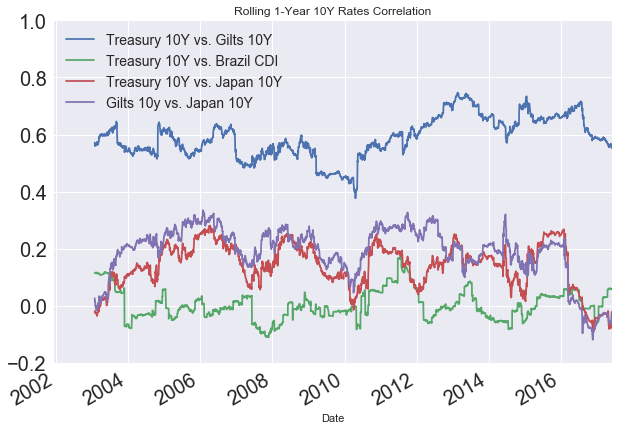

In [39]:
#Rolling Correlations
q = pd.rolling_corr(log_rates.US, log_rates.UK, window=252)
w = pd.rolling_corr(log_rates.US, log_rates.CDI, window=252)
r = pd.rolling_corr(log_rates.US, log_rates.Japan, window=252)
s = pd.rolling_corr(log_rates.UK, log_rates.Japan, window=252)
df = pd.concat([q,w,r,s], axis=1)
df.columns = ['Treasury 10Y vs. Gilts 10Y', 'Treasury 10Y vs. Brazil CDI', 
              'Treasury 10Y vs. Japan 10Y', 'Gilts 10y vs. Japan 10Y']
ax = df.plot(figsize=(10,7), legend=True, fontsize=20, title='Rolling 1-Year 10Y Rates Correlation')
ax.legend(loc=2, fontsize=14)
ax.set_ylim(bottom = -0.2, top=1)

### Percentiles

(array([1, 2, 3, 4]), <a list of 4 Text xticklabel objects>)

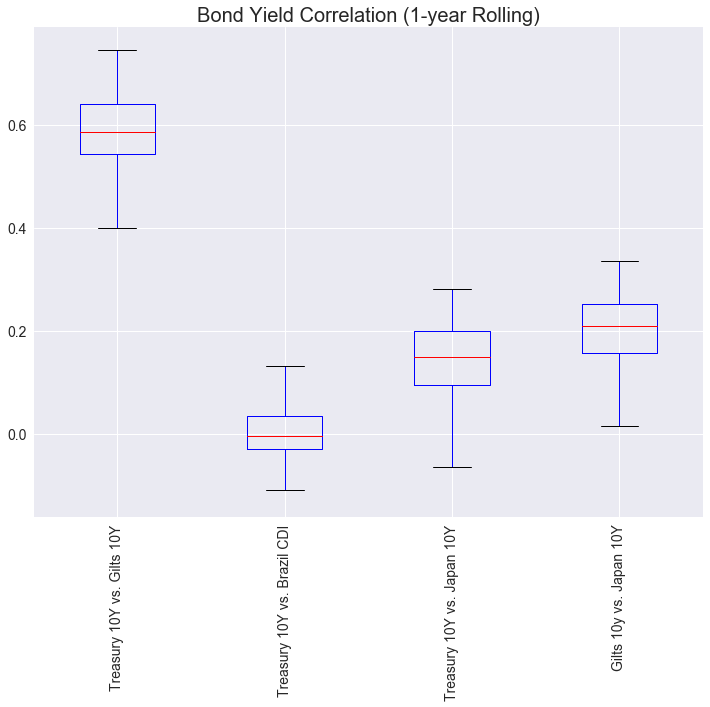

In [40]:
ax = df.plot.box(figsize=(12,9), fontsize=14)
plt.title('Bond Yield Correlation (1-year Rolling)', fontsize=20)
plt.xticks(rotation=90)

# 4.) Cross-Asset Valuation

In [41]:
count = 0
df = pd.DataFrame(index=['Valuation','Metric', 'Average','Percentiles', 'Current (%)', '95th %ile', '5th %ile'], columns=valuations.columns)
for i in valuations.columns:
    df[i]['Valuation'] = ''
    df[i]['Metric'] = (valuations[i].round(1).dropna(how='any').iloc[-1])
    df[i]['Average'] = np.average(valuations[i].dropna()).round(2)
    df[i]['Percentiles'] = ''
    df[i]['Current (%)'] = stats.percentileofscore(a = valuations[i].dropna(), score = df[i]['Metric']).round(1)
    df[i]['95th %ile'] = np.percentile(a=valuations[i].dropna(), q=95).round(2)
    df[i]['5th %ile'] = np.percentile(a=valuations[i].dropna(), q=5).round(2)
df

,AUDUSD,EURUSD,USDBRL,S&P 500,Germany 10Y,US 10Y,UK 10Y,S&P 500 Schiller
Valuation,,,,,,,,
Metric,0.7,1.1,3.3,24.9,0.3,2.2,1.1,29
Average,0.88,1.21,2.12,15.64,2.76,6.29,4.52,16.74
Percentiles,,,,,,,,
Current (%),19.7,29,92.6,94.5,7.4,6,1.8,96.2
95th %ile,1.31,1.47,3.53,25.82,4.55,11.97,8.18,27.55
5th %ile,0.57,0.89,0.99,7.82,0.21,2.13,1.5,7.83


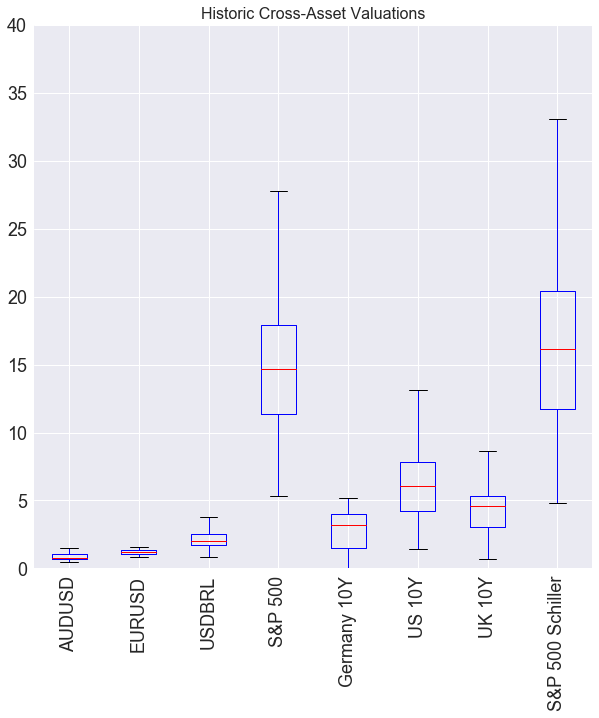

In [42]:
tmp2 = valuations
ax = tmp2.plot.box()
ax.set_ylim(bottom=0, top=40)
ax.grid(True)

plt.xticks(rotation=90)
plt.title( 'Historic Cross-Asset Valuations', fontsize=16)

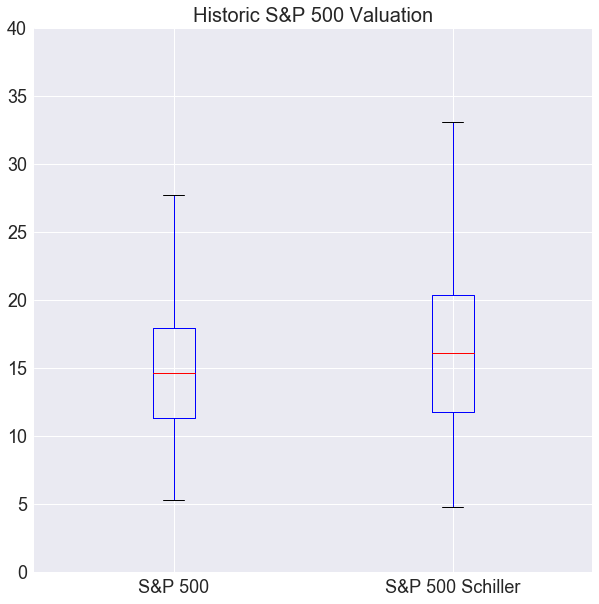

In [43]:
ax = valuations[['S&P 500', 'S&P 500 Schiller']].plot.box()
ax.set_ylim(bottom=0, top=40)
plt.title('Historic S&P 500 Valuation', fontsize=20)

# 5.) Cross-Asset Yields

In [44]:
def cross_yields(data):
    df = pd.DataFrame(columns=data.columns, 
                      index=['Yields','Metric', 'Average','Percentiles', 'Current %', '95th %ile', '5th %ile'])
    for i in data:
        df[i]['Yields'] = ''
        df[i]['Metric'] = data[i].dropna().iloc[-1].round(2)
        df[i]['Average'] = np.average(data[i].dropna()).round(2)
        df[i]['Percentiles'] = ''
        df[i]['Current %'] = stats.percentileofscore(a = data[i].dropna(), score = df[i]['Metric']).round(1)
        df[i]['95th %ile'] = np.percentile(a=data[i].dropna(), q=95).round(2)
        df[i]['5th %ile'] = np.percentile(a=data[i].dropna(), q=5).round(2)
    return df
x = cross_yields(asset_yields)
x

,US Corporates,UK 10Y,US BB rated,S&P 500,Germany 10Y,US 10Y,US CCC rated,CDI,EM High Grade,US A rated,US BBB rated,Euro EM,US B rated,Aussie 10Y,Japan 10Y,US High Yield,US AAA rated,Swiss 10Y,US AA rated,Canada 10Y
Yields,,,,,,,,,,,,,,,,,,,,
Metric,3.39,1.28,4.72,2.03,0.19,2.45,11.49,13.63,3.51,3.11,3.8,1.77,6.09,2.24,0.04,6.19,3.05,-0.08,2.76,1.72
Average,5.17,4.4,7.34,1.87,2.82,4.14,15.19,18.05,5.48,4.94,5.73,6.25,9.18,2.48,1.42,9.27,4.38,2.29,4.47,3.27
Percentiles,,,,,,,,,,,,,,,,,,,,
Current %,19.1,1.9,7.7,68,4.9,19.3,29.5,39.4,12,22.8,14.5,0.5,7.3,48.9,3.8,8.7,32.6,7.2,24.9,14.9
95th %ile,7.81,7.95,10.46,2.6,4.55,6.64,26.25,39.4,8.5,7.6,8.24,12.01,13.89,3.41,3.09,13.67,6.98,4.3,7.22,5.08
5th %ile,2.91,1.63,4.65,1.21,0.21,1.75,9.23,8.34,3.24,2.53,3.42,2.9,5.8,1.62,0.29,5.93,2,-0.2,2.14,1.3


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]), <a list of 20 Text xticklabel objects>)

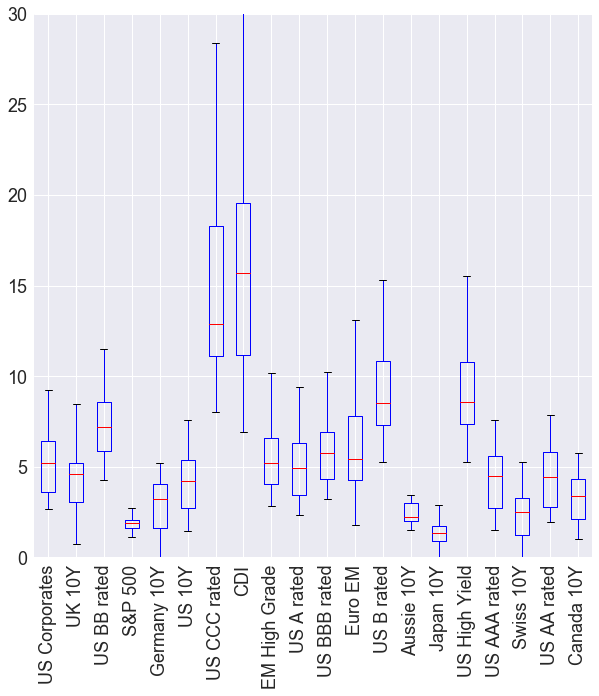

In [45]:
ax = asset_yields.plot.box()
ax.set_ylim(bottom=0, top=30)
plt.xticks(rotation=90)

# 6.) Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

### 1.) Coefficient Betas of Currencies vs. WTI Crude Oil

In [11]:
#Create empty Series to store reiteration of Data (Since 2000)
betas = pd.Series()
oil = asset_classes['cmds'].WTI.dropna()
pairs = asset_classes['fx']
pairs = pd.concat([pairs, oil], axis=1).dropna()
pairs.USDJPY = 1/pairs.USDJPY
pairs.USDBRL = 1/pairs.USDBRL
pairs.USDCAD = 1/pairs.USDCAD

pairs = np.log(pairs/pairs.shift(1)).dropna()
pairs.columns = ['AUD', 'EUR', 'USD', 'JPY', 'BRL','CAD', 'WTI']

#Daily Changes since 2000
for i in pairs.iloc[:,0:6]:
    betas[i] = pd.ols(y = pairs[i], x=pairs.WTI).beta[0]

betas.index = ['AUD', 'EUR', 'USD', 'JPY', 'BRL','CAD']
betas.sort(ascending=True, axis=1)

#Rolling 6-month coefficient
betas6m = pd.Series()
for i in pairs.iloc[-150:,0:6]:
    betas6m[i] = pd.ols(y = pairs[i].iloc[-150:], x=pairs.WTI.iloc[-150:]).beta[0]

#Reindex 
betas6m = betas6m.reindex(betas.index)

#Return
betas, betas6m

/Users/NABRARPOUR4/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


(USD   -0.044678
 JPY   -0.015814
 EUR    0.043007
 CAD    0.074995
 BRL    0.094143
 AUD    0.096269
 dtype: float64, USD   -0.013083
 JPY    0.005175
 EUR   -0.018075
 CAD    0.069036
 BRL    0.084199
 AUD    0.013746
 dtype: float64)

* FX Betas to Oil are significantly lower in the past 6-months relative to the data since 2000

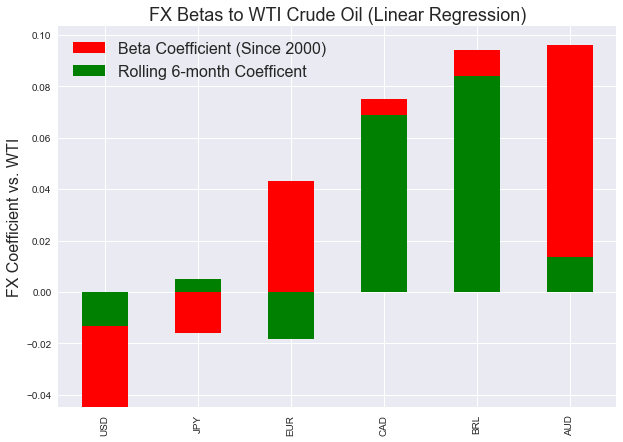

In [12]:
#Plot
fig = plt.figure(figsize=(10,7)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes

betas.plot.bar(label='Beta Coefficient (Since 2000)',color='r',ax=ax)
betas6m.plot.bar(ax=ax,color='g',label='Rolling 6-month Coefficent')

ax.set_ylabel('FX Coefficient vs. WTI', fontsize=16)
ax.grid(True)
ax.legend(loc=2, fontsize=16)

plt.title('FX Betas to WTI Crude Oil (Linear Regression)', fontsize=18)
plt.show()

#### Linear Regression - Aussia Dollar vs. Oil

In [13]:
pd.ols(y = pairs.AUD, x = pairs.WTI)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         4330
Number of Degrees of Freedom:   2

R-squared:         0.0793
Adj R-squared:     0.0791

Rmse:              0.0081

F-stat (1, 4328):   372.7919, p-value:     0.0000

Degrees of Freedom: model 1, resid 4328

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.0963     0.0050      19.31     0.0000     0.0865     0.1060
     intercept     0.0000     0.0001       0.12     0.9083    -0.0002     0.0003
---------------------------------End of Summary---------------------------------

#### Linear Regression - Canadian Dollar vs. Oil

In [14]:
pd.ols(y = pairs.CAD, x = pairs.WTI)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         4330
Number of Degrees of Freedom:   2

R-squared:         0.0997
Adj R-squared:     0.0994

Rmse:              0.0055

F-stat (1, 4328):   479.0235, p-value:     0.0000

Degrees of Freedom: model 1, resid 4328

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.0750     0.0034      21.89     0.0000     0.0683     0.0817
     intercept     0.0000     0.0001       0.07     0.9433    -0.0002     0.0002
---------------------------------End of Summary---------------------------------

## Multiple Regression

In [25]:
y = returns_daily['Dollar TWI']
x = returns_daily[['S&P 500', 'Gold', 'US 10Y', 'WTI']]

def reg_m(y, x):
    ones = np.ones(len(y))
    X = sm.add_constant(np.column_stack((x.iloc[:,0], ones)))
    for i in x.iloc[:,1:]:
        X = sm.add_constant(np.column_stack((x[i], X)))
    results = sm.OLS(y, X).fit()
    return results

#### Summary

In [26]:
mult_reg = reg_m(y, x)
mult_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Dollar TWI   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     297.9
Date:                Fri, 02 Jun 2017   Prob (F-statistic):          1.81e-227
Time:                        10:45:11   Log-Likelihood:                 18284.
No. Observations:                4479   AIC:                        -3.656e+04
Df Residuals:                    4474   BIC:                        -3.653e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0235      0.003     -8.674      0.000      -0.029      -0.018
x2             0.0111      0.003      3.165      0.002       0.004       0.018
x3            -0.1494      0.005    -28.049      0.000      -0.160      -0.139
x4            -0.0469      0.005     -8.729      0.000      -0.057      -0.036
const       5.322e-05   6.11e-05      0.872      0.383   -6.65e-05       0.000
==============================================================================
Omnibus:                      397.383   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2217.514
Skew:                          -0.220   Prob(JB):                         0.00
Kurtosis:                       6.419   Cond. No.                         91.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Coefficients of Independent Factors

x1      -0.023464
x2       0.011051
x3      -0.149439
x4      -0.046879
const    0.000053
dtype: float64

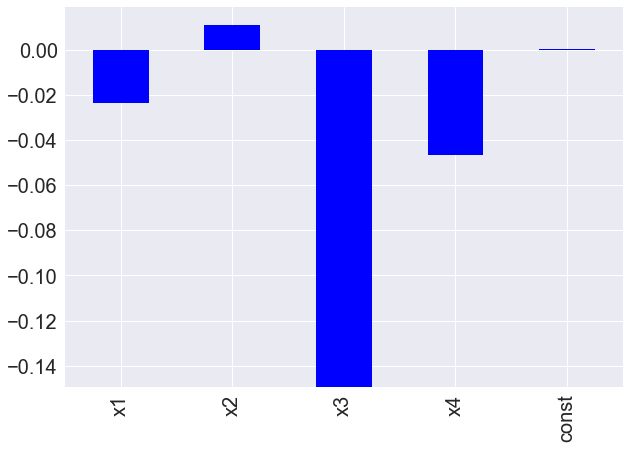

In [27]:
mult_reg.params.plot.bar(figsize=(10,7), fontsize=20)
mult_reg.params

### Factor Coefficients

In [28]:
regressor = LinearRegression()
regressor.fit(x,y)
print (regressor.coef_)

[-0.04687883 -0.14943926  0.011051   -0.02346431]


### R-Squared

In [29]:
mult_reg.rsquared, mult_reg.rsquared_adj

(0.21033210150014525, 0.20962609533251009)

### T-values

In [30]:
mult_reg.tvalues

x1       -8.674283
x2        3.164893
x3      -28.048919
x4       -8.729419
const     0.871699
dtype: float64